<img src='http://greenteapress.com/thinkstats/think_stats_comp.png'>

# Effect Size

---

### Question: Are Men Taller Than Women? 

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as pyplot
from ipywidgets import interact, fixed
import seaborn as sns

sns.set_context('notebook')
sns.set_style('darkgrid')

np.random.seed(17)

<big>

<br>

## Getting data from the Normal Distribution
---
    
* To explore statistics that quantify effect size, we'll look at the difference in height between men and women. 
* We'll use `scipy.stats.norm` to represent the distributions.  
* The result is an `rv` object (which stands for random variable).
* We can use the `.pdf()` method of these objects to draw samples

<br>

In [3]:
mu1, sig1 = 178, 7.7
male_height = stats.norm(mu1, sig1)

In [4]:
mu2, sig2 = 163, 7.3
female_height = stats.norm(mu2, sig2)

The following function evaluates the normal (Gaussian) probability density function (PDF) within 4 standard deviations of the mean.  It takes and rv object and returns a pair of NumPy arrays.

In [5]:
x_axis = np.linspace(start=(mu2-4*sig1), stop=(mu1+4*sig1), num=100)

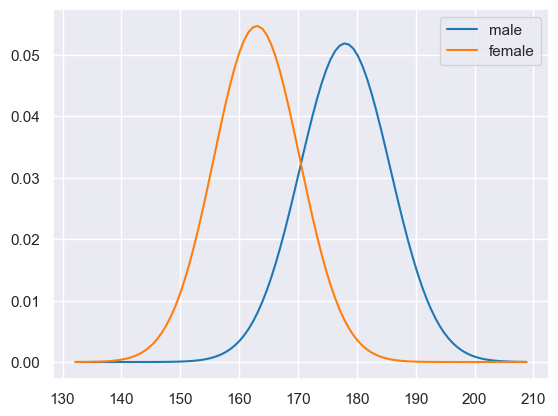

In [7]:
ax = pd.Series(male_height.pdf(x_axis), name='male', index=x_axis).plot()
pd.Series(female_height.pdf(x_axis), name='female', index=x_axis).plot(ax=ax)
ax.legend()

<big>

Let's assume for now that those are the true distributions for the population.  

> Of course, in real life we never observe the true population distribution.  We generally have to work with a random sample.

I'll use `rvs` to generate random samples from the population distributions.  Note that these are totally random, totally representative samples, with no measurement error!

In [8]:
male_sample = male_height.rvs(1000)
female_sample = female_height.rvs(1000)

In [9]:
male_sample[:15].round(2)

array([180.13, 163.72, 182.8 , 186.82, 185.99, 192.53, 177.14, 175.21,
       179.14, 174.63, 194.72, 186.87, 164.  , 176.94, 182.16])

In [10]:
female_sample[:15].round(2)

array([164.5 , 160.28, 167.83, 160.75, 164.11, 155.73, 159.92, 172.73,
       165.14, 154.47, 148.59, 169.03, 157.21, 164.26, 156.52])

Both samples are NumPy arrays.  Now we can compute sample statistics like the mean and standard deviation.

In [11]:
mean1, std1 = male_sample.mean(), male_sample.std()
mean1, std1

(np.float64(178.16511665818112), np.float64(7.84199617128995))

The sample mean is close to the population mean, but not exact, as expected.

In [12]:
mean2, std2 = female_sample.mean(), female_sample.std()
mean2, std2

(np.float64(163.48610226651135), np.float64(7.382384919896662))

<big>

<br>

And the results are similar for the female sample.


Now, there are many ways to **describe the magnitude of the difference** between these distributions.  <br><br> 

## 1. Difference in Means

In [13]:
difference_in_means = mean1 - mean2
difference_in_means # in cm

np.float64(14.679014391669767)

<big>

**On average, men are 14-15 centimeters taller.**  

For some applications, that would be a good way to describe the difference, but there are a few problems:

<br>
* Without knowing more about the distributions (like the standard deviations) it's **hard to interpret whether a difference like 15 cm is a lot or not.**

* The magnitude of the difference **depends on the units of measure**, making it hard to compare across different studies.

---

There are a number of ways to quantify the difference between distributions.  

[_METHOD 2_] A simple option is to **express the difference as a percentage of the mean.**

In [14]:
# Exercise: what is the relative difference in means, expressed as a percentage?

relative_difference = difference_in_means / male_sample.mean()
relative_difference * 100   # percent

np.float64(8.238994628691657)

But a problem with relative differences is that you have to choose which mean to express them relative to.

In [15]:
relative_difference = difference_in_means / female_sample.mean()
relative_difference * 100    # percent

np.float64(8.97875366050404)

<br>

<big>

## 2. Overlap
---

An alternative way to express the difference between distributions is to **see how much they overlap.**  


- To define overlap, we **choose a threshold between the two means.** The simple threshold is the midpoint between the means:

In [16]:
simple_thresh = (mean1 + mean2) / 2
simple_thresh

np.float64(170.82560946234622)

### One way to use this threshold is as a simple model.

```python
if (height_of_person > thresh):
    print("this person is likely to be male")
else:
    print("this person is likely to be female")
```

<br>

A better, but slightly more complicated threshold is the place where the PDFs cross.

In [17]:
thresh = (std1 * mean2 + std2 * mean1) / (std1 + std2)
thresh

np.float64(170.6040359174722)

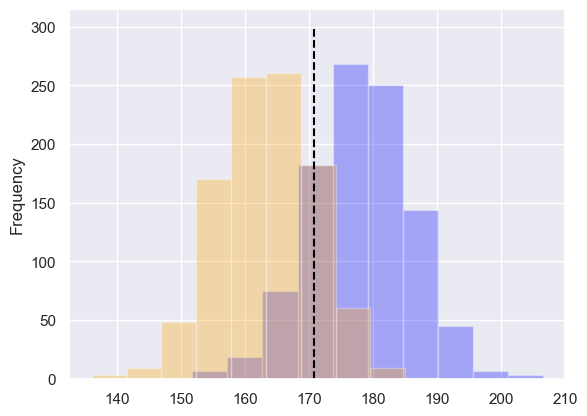

In [26]:
ax = pd.Series(male_sample).plot.hist(color='blue', alpha=0.3)
pd.Series(female_sample).plot.hist(color='orange', ax=ax, alpha=0.3)
ax.vlines(x=simple_thresh, ymin=0, ymax=300, color='black', linestyle='--');

In this example, there's not much difference between the two thresholds.

Now we can count how many men are below the threshold:

In [27]:
male_below_thresh = sum(male_sample < thresh)
male_below_thresh

np.int64(164)

And how many women are above it:

In [28]:
female_above_thresh = sum(female_sample > thresh)
female_above_thresh

np.int64(174)

The "overlap" is the total area under the curves that ends up on the wrong side of the threshold.

In [29]:
overlap = male_below_thresh / len(male_sample) + female_above_thresh / len(female_sample)
overlap

np.float64(0.33799999999999997)

Or in more practical terms, you might report the fraction of people who would be misclassified if you tried to use height to guess sex:

In [30]:
misclassification_rate = overlap / 2
misclassification_rate

np.float64(0.16899999999999998)

---

Another way to quantify the difference between distributions is what's called 

### "probability of superiority",

which is a problematic term, but in this context it's the probability that a randomly-chosen man is taller than a randomly-chosen woman.

In [47]:
def ht_female():
    return pd.Series(female_sample).sample(1).iloc[0]

def ht_male():
    return pd.Series(male_sample).sample(1).iloc[0]

In [55]:
pd.Series([ht_male() > ht_female() for x in range(20_000)]).value_counts(normalize=True)

True     0.9141
False    0.0859
Name: proportion, dtype: float64

<big>

---

Overlap (or misclassification rate) and "probability of superiority" have two good properties:

* As probabilities, they don't depend on units of measure, so they are comparable between studies.

* They are expressed in operational terms, so a reader has a sense of what practical effect the difference makes.

---

### Cohen's D

There is one other common way to express the difference between distributions.  Cohen's $d$ is the difference in means, standardized by dividing by the standard deviation.  Here's a function that computes it:


---

In [58]:
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    d = diff / numpy.sqrt(pooled_var)
    return d

Computing the denominator is a little complicated; in fact, people have proposed several ways to do it.  This implementation uses the "pooled standard deviation", which is a weighted average of the standard deviations of the two groups.

And here's the result for the difference in height between men and women.

In [43]:
CohenEffectSize(male_sample, female_sample)

1.9274780043619493

Most people don't have a good sense of how big $d=1.92$   is, so let's make a visualization to get calibrated.

Here's a function that encapsulates the code we already saw for computing overlap and probability of superiority.

In [44]:
def overlap_superiority(control, treatment, n=1000):
    """Estimates overlap and superiority based on a sample.
    
    control: scipy.stats rv object
    treatment: scipy.stats rv object
    n: sample size
    """
    control_sample = control.rvs(n)
    treatment_sample = treatment.rvs(n)
    thresh = (control.mean() + treatment.mean()) / 2
    
    control_above = sum(control_sample > thresh)
    treatment_below = sum(treatment_sample < thresh)
    overlap = (control_above + treatment_below) / n
    
    superiority = sum(x > y for x, y in zip(treatment_sample, control_sample)) / n
    return overlap, superiority

Here's the function that takes Cohen's $d$, plots normal distributions with the given effect size, and prints their overlap and superiority.

In [45]:
def plot_pdfs(cohen_d=2):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    control = scipy.stats.norm(0, 1)
    treatment = scipy.stats.norm(cohen_d, 1)
    xs, ys = eval_pdf(control)
    pyplot.fill_between(xs, ys, label='control', color=COLOR3, alpha=0.7)

    xs, ys = eval_pdf(treatment)
    pyplot.fill_between(xs, ys, label='treatment', color=COLOR2, alpha=0.7)
    
    o, s = overlap_superiority(control, treatment)
    print('overlap', o)
    print('superiority', s)

Here's an example that demonstrates the function:

overlap 0.039
superiority 1.0


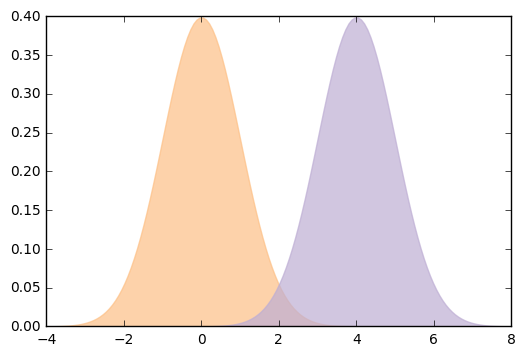

In [46]:
plot_pdfs(4);

And an interactive widget you can use to visualize what different values of $d$ mean:

In [47]:
from IPython.html.widgets import interact, fixed
from IPython.html import widgets

In [ ]:
widgets.

overlap 0.045
superiority 0.999


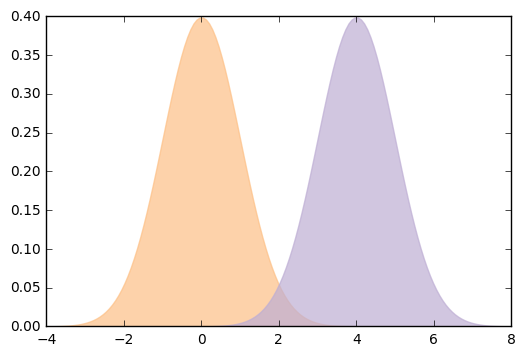

In [48]:
slider = widgets.FloatSlider(min=0, max=4, value=2)
interact(plot_pdfs, cohen_d=slider)
None

<big>

Cohen's $d$ has a few nice properties:

* Because mean and standard deviation have the same units, their ratio is dimensionless, so we can compare $d$ across different studies.

* In fields that commonly use $d$, people are calibrated to know what values should be considered big, surprising, or important.

* Given $d$ (and the assumption that the distributions are normal), you can compute overlap, superiority, and related statistics.

<big>

In summary, the best way to report effect size often depends on the audience and your goals.  There is often a tradeoff between summary statistics that have good technical properties and statistics that are meaningful to a general audience.

---
## Further reading

- Think Stats, http://greenteapress.com/thinkstats/
- ANOVA (wikipedia)    
- Bayesian Methods for Hackers

In [1]:
import pandas as pd

In [6]:
cars = pd.read_csv('./data/mtcars.csv')

In [10]:
aut = cars.query("am == 1.0")['mpg']
mnl = cars.query("am == 0.0")['mpg']

In [16]:
cnt = 0
for i in range(10**4):
    if aut.sample(1).iloc[0] < mnl.sample(1).iloc[0]:
        cnt += 1
        
cnt/float(10**4)        

0.1668